# Conformal Prediction Models

The following is a in depth demonstration of the regression models in Darts - from basic to advanced features, including:

- Darts' regression models
- lags and lagged data extraction
- covariates usage
- parameters output_chunk_length in relation with multi_models
- one-shot and auto-regressive predictions
- multi output support
- probablistic forecasting
- explainability
- and more

In [2]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

# activate javascript
from shap import initjs

initjs()

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

from darts import concatenate, metrics
from darts.datasets import ElectricityConsumptionZurichDataset
from darts.models import ConformalNaiveModel, LinearRegressionModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input Dataset
For this notebook, we use the Electricity Consumption Dataset from households in Zurich, Switzerland.

The dataset has a quarter-hourly frequency (15 Min time intervals), but we resample it to hourly 
frequency to keep things simple.

**Target series** (the series we want to forecast):
- **Value_NE5**: Electricity consumption by households on grid level 5 (in kWh).

**Covariates** (external data to help improve forecasts):
The dataset also comes with weather measurements that we can use as covariates. For simplicity, we use:
- **T [°C]**: Measured temperature
- **StrGlo [W/m2]**: Measured solar irradation
- **RainDur [min]**: Measured raining duration

/Users/dennisbader/miniconda3/envs/darts310/lib/python3.10/site-packages/xarray/groupers.py:403: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.index_grouper = pd.Grouper(


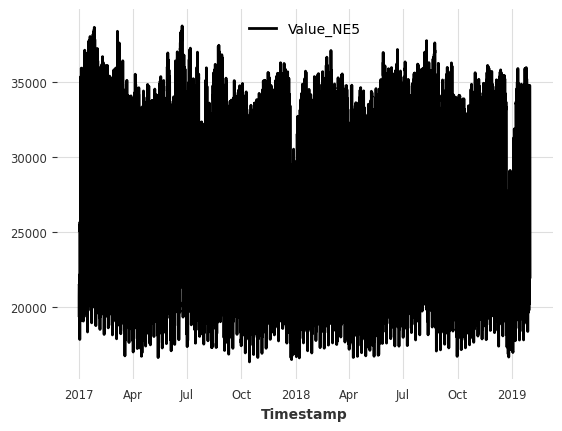

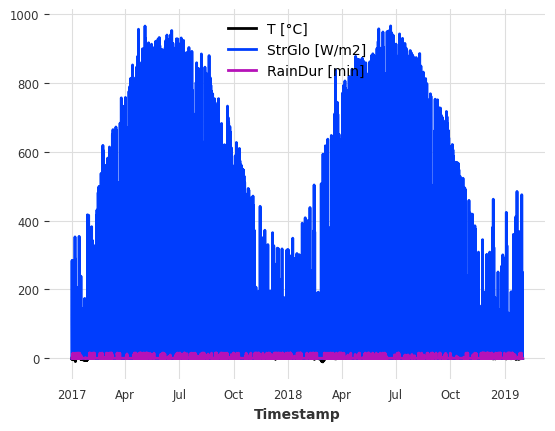

In [5]:
ts_energy = ElectricityConsumptionZurichDataset().load()

# extract values recorded between 2017 and 2019
start_date = pd.Timestamp("2017-01-01")
end_date = pd.Timestamp("2019-01-31")
ts_energy = ts_energy[start_date:end_date]

# resample to hourly frequency
ts_energy = ts_energy.resample(freq="H")

# extract temperature, solar irradiation and rain duration
ts_weather = ts_energy[["T [°C]", "StrGlo [W/m2]", "RainDur [min]"]]

# extract households energy consumption
ts_energy = ts_energy["Value_NE5"]

# create train and validation splits
validation_cutoff = pd.Timestamp("2018-10-31")
ts_energy_train, ts_energy_val = ts_energy.split_after(validation_cutoff)

ts_energy.plot()
plt.show()

ts_weather.plot()
plt.show()

## Darts Conformal Prediction Models

*Conformal prediction is a technique for constructing prediction intervals that try to achieve valid coverage in finite samples, without making distributional assumptions.* [(source)](https://arxiv.org/pdf/1905.03222)

In other words: If we want a prediction interval that includes 80% of all actual values over some period of time, then a conformal model tries to build such an interval with actually has 80% of points inside.
... WIP

<Axes: xlabel='Timestamp'>

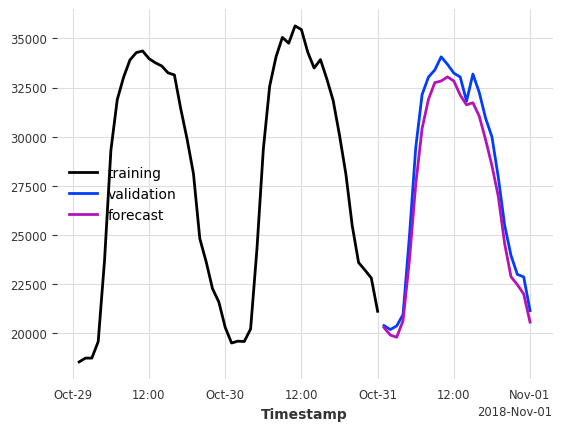

In [85]:
input_length = 24
horizon = 24

model = LinearRegressionModel(lags=input_length, output_chunk_length=horizon)
model.fit(ts_energy_train)
pred = model.predict(horizon)

ts_energy_train[-2 * horizon :].plot(label="training")
ts_energy_val[:horizon].plot(label="validation")
pred.plot(label="forecast")

### Hist fc over validation series

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

2527.8057652310067


<Axes: xlabel='Timestamp'>

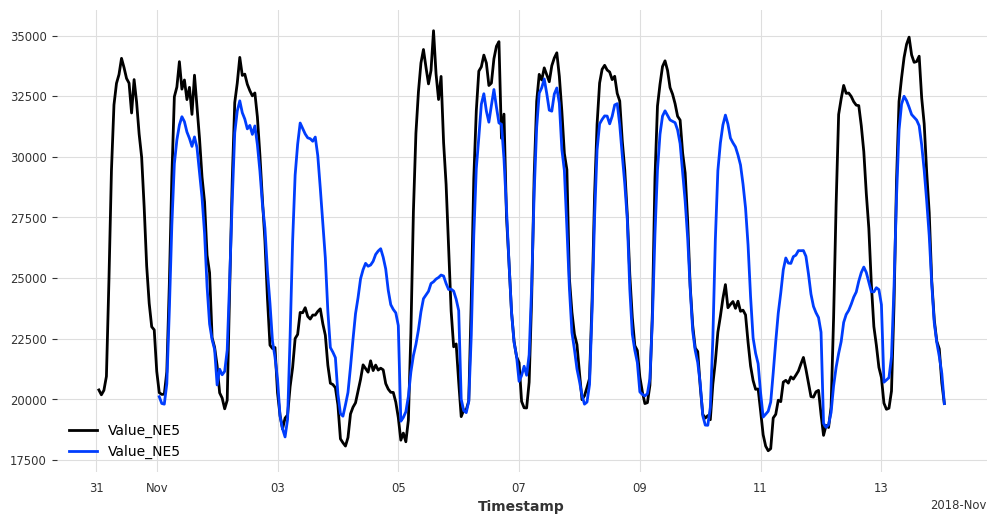

In [86]:
hist_fc = model.historical_forecasts(
    series=ts_energy_val,
    forecast_horizon=horizon,
    stride=horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
hist_fc = concatenate(hist_fc)
print(metrics.mae(ts_energy_val, hist_fc))

fig, ax = plt.subplots(figsize=(12, 6))
end_ts = ts_energy_val.start_time() + 2 * 7 * horizon * ts_energy_val.freq
ts_energy_val[:end_ts].plot()
hist_fc[:end_ts].plot()

### Point Forecasts Are not so good
No idea about uncertainty. Can we do better?

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/83 [00:00<?, ?it/s]

<Axes: xlabel='Timestamp'>

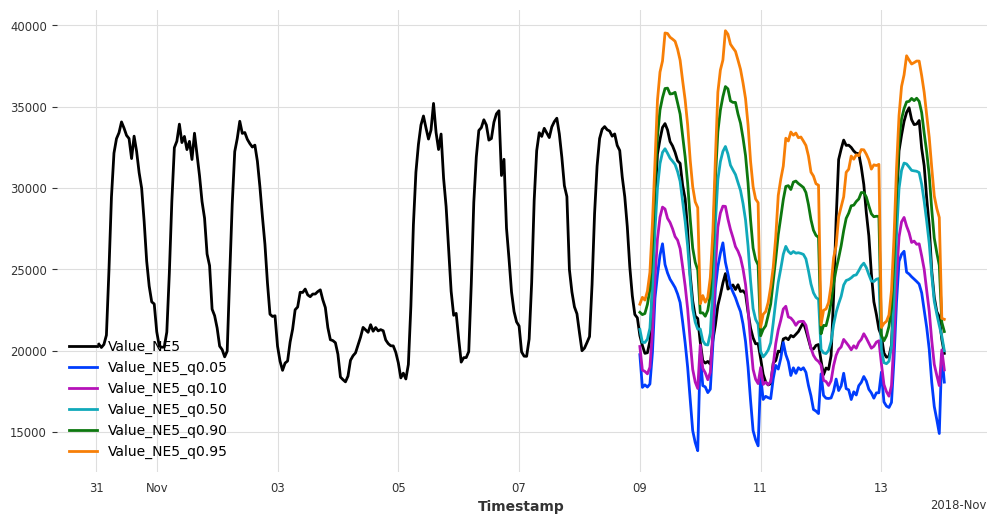

In [37]:
quantiles = [0.05, 0.1, 0.5, 0.9, 0.95]
cp_model = ConformalNaiveModel(model=model, quantiles=quantiles, cal_length=7 * horizon)
pred_params = {"predict_likelihood_parameters": True}
# pred_params = {"num_samples": 500}

cp_hist_fc = cp_model.historical_forecasts(
    series=ts_energy_val,
    forecast_horizon=horizon,
    stride=horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
    **pred_params,
)
cp_hist_fc = concatenate(cp_hist_fc)

fig, ax = plt.subplots(figsize=(12, 6))
ts_energy_val[:end_ts].plot()
cp_hist_fc[:end_ts].plot()

### What's the overall coverage?

In [47]:
def compute_backtest(forecasts):
    bt = cp_model.backtest(
        series=ts_energy_val,
        historical_forecasts=forecasts,
        last_points_only=True,
        metric=[metrics.miw, metrics.mic],
        metric_kwargs={"q_interval": cp_model.q_interval},
    )
    bt_df = pd.DataFrame(bt).T
    bt_df.columns = ["q0.05-q0.95", "q0.1-q0.9"]
    bt_df.index = ["Interval Width", "Interval Coverage"]
    return bt_df


print(compute_backtest(cp_hist_fc))

                    q0.05-q0.95    q0.1-q0.9
Interval Width     10054.736762  6305.233124
Interval Coverage      0.851908     0.719880


Ideally we should be at 90% and 80% overall coverage

### What's the interval width over time?

<Axes: xlabel='Timestamp'>

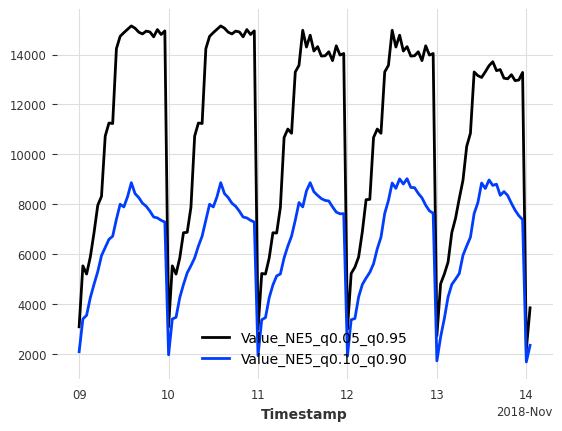

In [71]:
def compute_residuals(forecasts, metric=metrics.ic):
    residuals = cp_model.residuals(
        series=ts_energy_val,
        historical_forecasts=forecasts,
        last_points_only=True,
        metric=metric,
        metric_kwargs={"q_interval": cp_model.q_interval},
    )
    return residuals


coverage = compute_residuals(cp_hist_fc, metric=metrics.iw)
coverage[:end_ts].plot()

Very nice to see increasing intervals for increasing forecast horizon (model was trained to predict 24 steps, we also use a stride of 24) -> thats why we see these ramps

### What's the coverage over time?

<Axes: xlabel='Timestamp'>

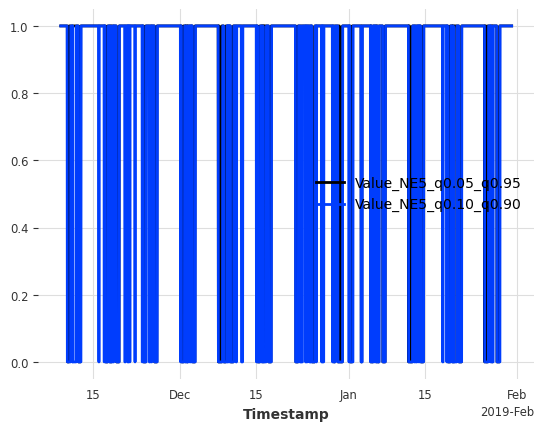

In [72]:
coverage = compute_residuals(cp_hist_fc, metric=metrics.ic)
coverage.plot()

# Not very informative, how about a windowed aggregation?

<Axes: xlabel='Timestamp'>

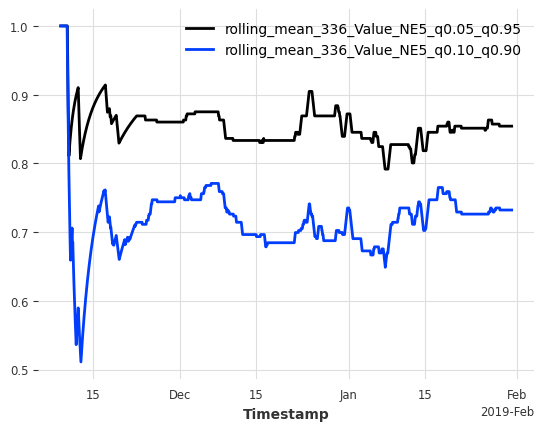

In [73]:
coverage.window_transform(
    transforms={"function": "mean", "mode": "rolling", "window": 2 * 7 * 24}
).plot()

Not too bad. What about an expanding calibration length?

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/90 [00:00<?, ?it/s]

                    q0.05-q0.95    q0.1-q0.9
Interval Width     10481.149683  6446.453437
Interval Coverage      0.881944     0.749537


<Axes: xlabel='Timestamp'>

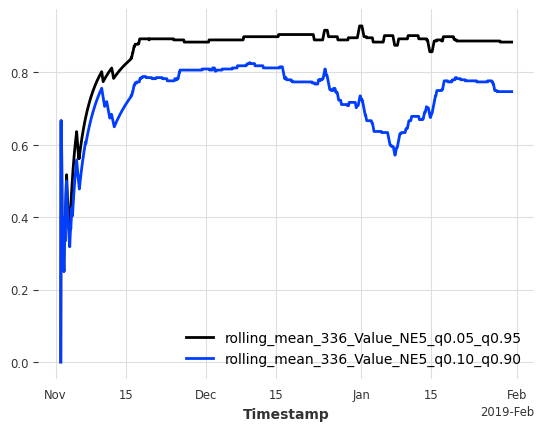

In [79]:
cp_model = ConformalNaiveModel(model=model, quantiles=quantiles, cal_length=None)

cp_hist_fc = cp_model.historical_forecasts(
    series=ts_energy_val,
    forecast_horizon=horizon,
    stride=horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
    **pred_params,
)
cp_hist_fc = concatenate(cp_hist_fc)
print(compute_backtest(cp_hist_fc))
coverage = compute_residuals(cp_hist_fc, metric=metrics.ic)
coverage.window_transform(
    transforms={"function": "mean", "mode": "rolling", "window": 2 * 7 * 24}
).plot()

Okay we're getting closer. Also, interesting to see the coverage drop for the smaller interval, but not for the large one.
This is (for the lower) because the calibration set is expanding, and our calibration cannot react to distribution shifts quickly anymore.

### Improving the underlying forecasting model
Let's add the day of the week to our forecasting model, see if it gets more accuracte, and what the influence is on our conformal model.

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

1937.624395420081


<Axes: xlabel='Timestamp'>

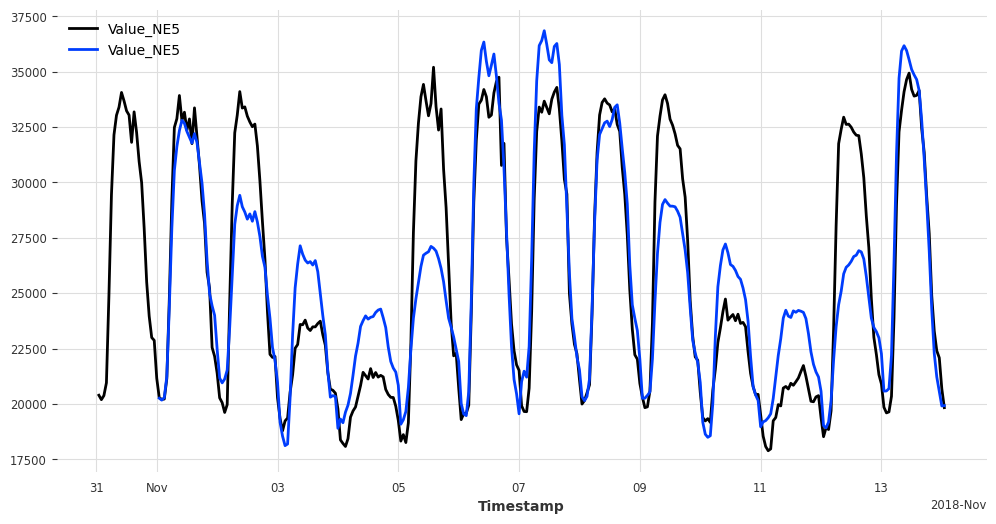

In [88]:
input_length = 24
horizon = 24

model = LinearRegressionModel(
    lags=input_length,
    lags_future_covariates=(input_length, horizon),
    output_chunk_length=horizon,
    add_encoders={"cyclic": {"future": ["dayofweek"]}},
)
model.fit(ts_energy_train)
hist_fc = model.historical_forecasts(
    series=ts_energy_val,
    forecast_horizon=horizon,
    stride=horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
hist_fc = concatenate(hist_fc)
print(metrics.mae(ts_energy_val, hist_fc))

fig, ax = plt.subplots(figsize=(12, 6))
end_ts = ts_energy_val.start_time() + 2 * 7 * horizon * ts_energy_val.freq
ts_energy_val[:end_ts].plot()
hist_fc[:end_ts].plot()

Forecast error is lower with the new model. And the conformal model?

historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

conformal forecasts:   0%|          | 0/90 [00:00<?, ?it/s]

                   q0.05-q0.95    q0.1-q0.9
Interval Width     8298.698320  5154.811224
Interval Coverage     0.862037     0.768981


<Axes: xlabel='Timestamp'>

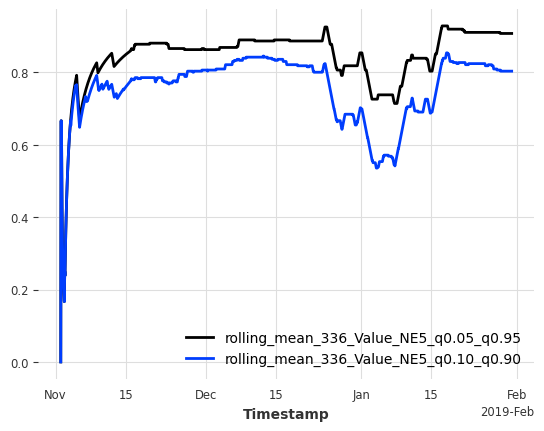

In [94]:
cp_model = ConformalNaiveModel(model=model, quantiles=quantiles, cal_length=None)

cp_hist_fc = cp_model.historical_forecasts(
    series=ts_energy_val,
    forecast_horizon=horizon,
    stride=horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
    **pred_params,
)
cp_hist_fc = concatenate(cp_hist_fc)
print(compute_backtest(cp_hist_fc))
coverage = compute_residuals(cp_hist_fc, metric=metrics.ic)
coverage.window_transform(
    transforms={"function": "mean", "mode": "rolling", "window": 2 * 7 * 24}
).plot()

Lower interval widths shile almost having the same coverage, nice. ...WIP